In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterstats import zonal_stats

In [2]:
import os
print(os.getcwd())

C:\Users\M533\Assignment


In [3]:
#Open the .tif which contains the NDVI calculation with rasterio
ndvi_path="Data_files/clipped_ndvi.tif"
ndvi=rio.open(ndvi_path)

#load the join shapefile
join_path = 'Data_files/joined_with_area.shp'
join = gpd.read_file(join_path)
join.drop('is_valid', axis=1, inplace=True)

#Make our projected overlay vector the same CRS as the imagery
temp = join.to_crs(crs=ndvi.crs.data)

#Define the parameters to calculate the zonal stats
array = ndvi.read(1)
affine = ndvi.transform
zs_ndvi = zonal_stats(temp, array, affine=affine, stats=['mean', 'min', 'max', 'std'])

#Append the results to a pandas' dataframe
ndviframe = pd.DataFrame(zs_ndvi)
join = join.join(ndviframe)

C:\Users\M533\anaconda3\envs\Assignment\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


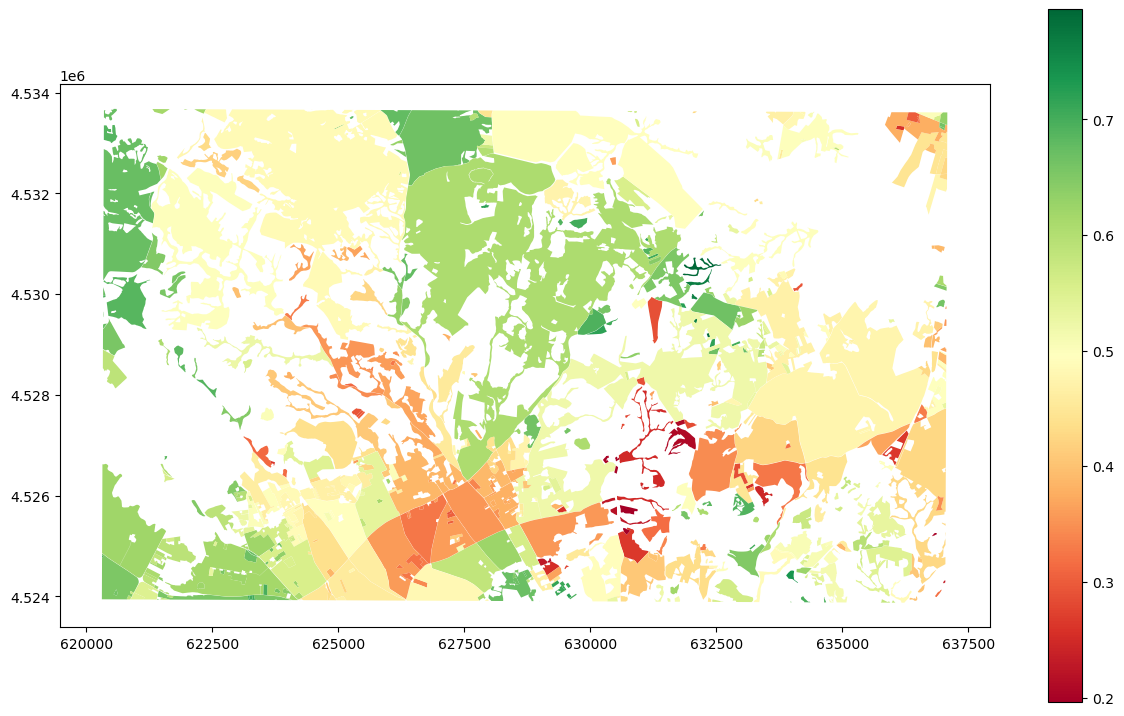

In [4]:
meanmap = join.plot(column='mean', cmap =    
                                'RdYlGn', figsize=(15,9), legend =  
                                  True);

In [5]:
join.to_file("Data_files/ZonalStatsNDVI_Polygons.geojson", driver='GeoJSON')

In [6]:
# Calculate the centroid of the area of interest
centroid = join.geometry.centroid
center_lat, center_lon = centroid.y.iloc[0], centroid.x.iloc[0]

import pyproj

# Define the UTM zone (e.g., UTM Zone 33N for Europe)
utm_zone = 33

# Create a UTM to latitude-longitude (WGS84) transformer
utm_to_wgs84 = pyproj.Transformer.from_crs(f'EPSG:326{utm_zone}', 'EPSG:4326', always_xy=True)

# Your provided UTM coordinates
utm_x, utm_y = center_lon, center_lat

# Convert to latitude and longitude
lon, lat = utm_to_wgs84.transform(utm_x, utm_y)

print(f"Latitude: {lat}, Longitude: {lon}")

Latitude: 40.86179941477147, Longitude: 16.481350328578195


In [7]:
import folium
m=join.explore('mean', cmap = 'RdYlGn')
m

In [75]:
#Open the raster file which contains the habitat connectivity calculation with rasterio
hab_con_path="Data_files/final.asc"

# Define the EPSG code for your desired coordinate system (e.g., EPSG:32633)
epsg_code = "EPSG:32633"

# Open the .asc file
with rio.open(hab_con_path) as src:
    # Create a new dataset with the same data and profile
    new_dataset = src.read(1)
    new_profile = src.profile

    # Set the CRS for the new dataset
    new_profile["crs"] = rio.crs.CRS.from_string(epsg_code)

    # Print the shape of the new dataset
    print(f"New dataset shape: {new_dataset.shape}")

    # Write the new dataset to a new file (e.g., "hab_con_epsg32633.asc")
    with rio.open("Data_files/hab_con_epsg32633.asc", "w", **new_profile) as dst:
        dst.write(new_dataset, indexes=1)

print(f"CRS set to {epsg_code} and saved to hab_con_epsg32633.asc")


New dataset shape: (1246, 1500)
CRS set to EPSG:32633 and saved to hab_con_epsg32633.asc


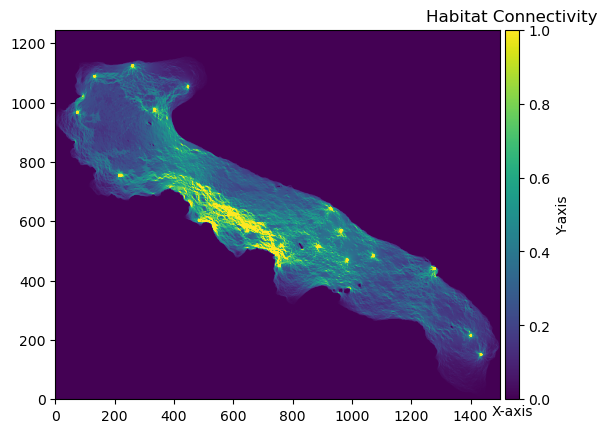

In [83]:
#Load the new reprojected raster file
hab_con_path="Data_files/hab_con_epsg32633.asc"

# Load the .asc file
hab_con = np.loadtxt(hab_con_path, skiprows=7)

# Create a new plot or use the existing one
fig, ax = plt.subplots()

#Define the extent of the map (you can adjust this based on your data)
map_extent = [0, hab_con.shape[1], 0, hab_con.shape[0]]

# Create a plot
img = plt.imshow(hab_con, extent=map_extent, cmap='viridis', vmin=0, vmax=1)

# Add colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05) 
cbar = plt.colorbar(img, cax=cax)

# Set plot title and labels
plt.title("Habitat Connectivity")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

In [74]:
#load the join shapefile
lastjoin_path = 'Data_files/ZonalStatsNDVI_Polygons.geojson'
lastjoin = gpd.read_file(lastjoin_path)

In [87]:
#Open the raster file which contains the habitat connectivity calculation with rasterio
hab_con_path = "Data_files/hab_con_epsg32633.asc"
hab_con = rio.open(hab_con_path)

# Load the join shapefile
lastjoin_path = "Data_files/ZonalStatsNDVI_Polygons.geojson"
lastjoin = gpd.read_file(lastjoin_path)

# Define the parameters to calculate the zonal stats
array = hab_con.read(1)
affine = hab_con.transform
zs_hab_con = zonal_stats(lastjoin, array, affine=affine, stats=["mean", "min", "max", "std"])

# Append the results to a pandas' dataframe
hab_con_frame = pd.DataFrame(zs_hab_con)
# Specify suffixes for overlapping columns
suffixes = "_hab"
lastjoin = lastjoin.join(hab_con_frame.add_suffix(suffixes))

In [126]:
lastjoin.to_file("Data_files/ZonalStatsNDVI_habitatconnectivity.geojson", driver='GeoJSON')

In [127]:
lastjoin_path = "Data_files/ZonalStatsNDVI_habitatconnectivity.geojson"
lastjoin = gpd.read_file(lastjoin_path)

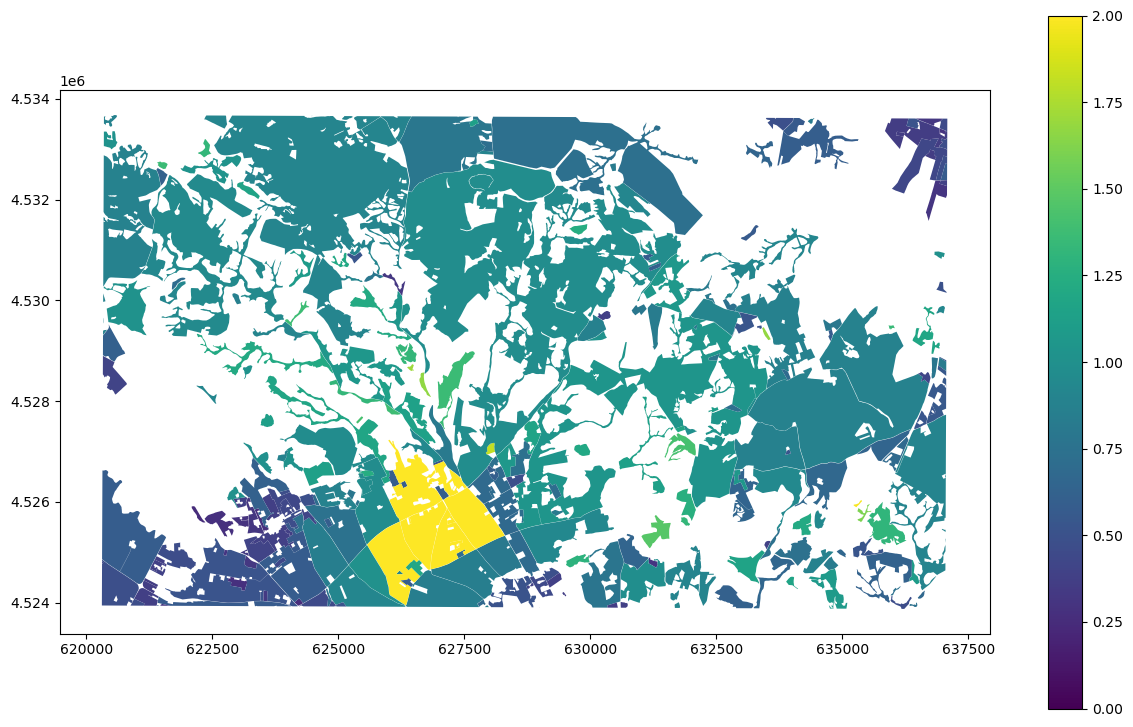

In [128]:
meanmap = lastjoin.plot(column='mean_hab', cmap =    
                                'viridis', vmin=0, vmax=2, figsize=(15,9), legend =  
                                  True);

In [148]:
lastjoin.groupby('DESC_')['surface_ha'].sum()

DESC_
areas mainly occupied by agricultural crops with the presence of natural spaces              4.792605
complex cultivation and parcel systems                                                       7.731964
horticultural crops in open fields in greenhouses and under plastic in irrigated areas       0.284144
olive groves                                                                               304.593058
orchards and minor fruits                                                                  119.329097
simple arable land in non-irrigated areas                                                 7848.030364
surfaces with dense herbaceous cover                                                         0.762053
temporary crops associated with permanent crops                                              5.831832
vineyards                                                                                   19.827999
Name: surface_ha, dtype: float64

In [129]:
# Calculate the correlation between columns 'column1' and 'column2'
correlation = lastjoin['mean'].corr(lastjoin['mean_hab'])
print(f"Pearson's correlation coefficient: {correlation:.2f}")

spearman_corr = lastjoin['mean'].corr(lastjoin['mean_hab'], method='spearman')
print(f"Spearman's rank correlation coefficient: {spearman_corr:.2f}")

Pearson's correlation coefficient: -0.21
Spearman's rank correlation coefficient: -0.23


In [130]:
# Calculate Pearson's correlation coefficient for each group
correlation_by_group = lastjoin.groupby('DESC_').apply(lambda group: group['mean'].corr(group['mean_hab']))

# Print the results
print("Correlation by group:")
print(correlation_by_group)

Correlation by group:
DESC_
areas mainly occupied by agricultural crops with the presence of natural spaces           1.000000
complex cultivation and parcel systems                                                    1.000000
horticultural crops in open fields in greenhouses and under plastic in irrigated areas         NaN
olive groves                                                                             -0.161546
orchards and minor fruits                                                                -0.220228
simple arable land in non-irrigated areas                                                -0.180573
surfaces with dense herbaceous cover                                                           NaN
temporary crops associated with permanent crops                                                NaN
vineyards                                                                                -0.485843
dtype: float64


C:\Users\M533\anaconda3\envs\Assignment\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\M533\anaconda3\envs\Assignment\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\M533\anaconda3\envs\Assignment\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\M533\AppData\Local\Temp\ipykernel_35332\2786942769.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_by_group = lastjoin.groupby('DESC_').apply(lambda gr

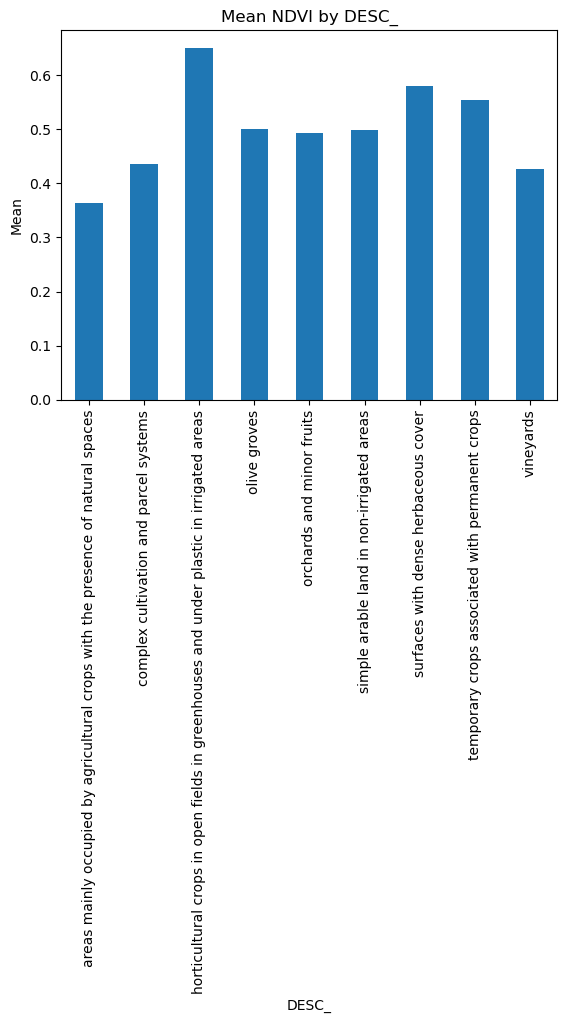

In [147]:
# Group by 'DESC_' and calculate the mean
NDVI_DESC = lastjoin.groupby('DESC_')['mean'].mean()
# Create a bar chart
NDVI_DESC.plot(kind='bar', rot=0)
plt.xlabel('DESC_')
plt.ylabel('Mean')
plt.title('Mean NDVI by DESC_')
#Set x-axis tick labels using the mapping
plt.xticks(range(len(grouped)), [label_to_name[i] for i in range(len(grouped))], rotation=90)
plt.show()

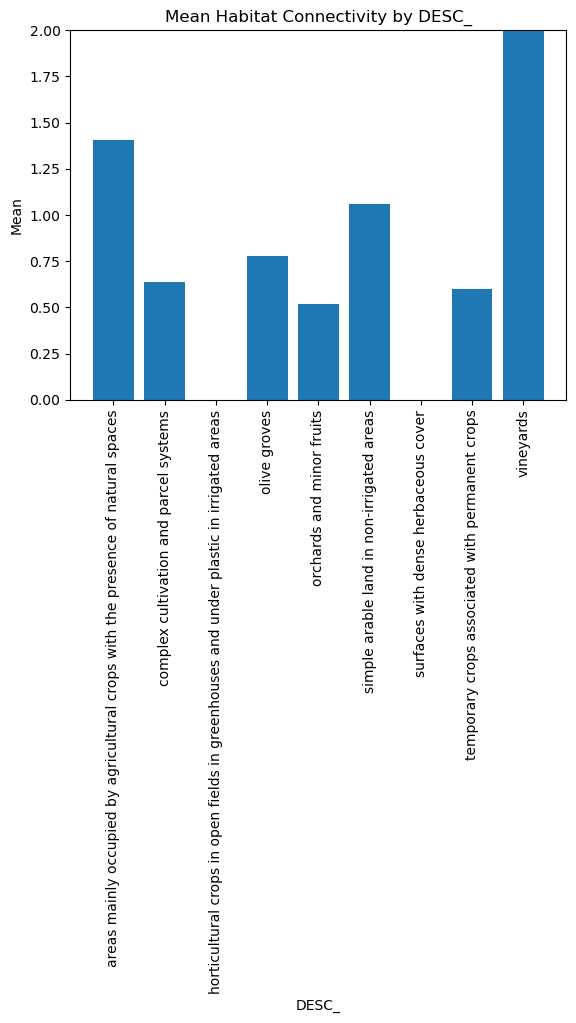

In [146]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'DESC_' and calculate the mean
grouped = lastjoin.groupby('DESC_')['mean_hab'].mean()

# Create a mapping between numerical labels and actual names
label_to_name = {i: name for i, name in enumerate(grouped.index)}

# Create a bar chart
plt.bar(range(len(grouped)), grouped.values)
plt.xlabel('DESC_')
plt.ylabel('Mean')
plt.ylim(0, 2)
plt.title('Mean Habitat Connectivity by DESC_')
#Set x-axis tick labels using the mapping
plt.xticks(range(len(grouped)), [label_to_name[i] for i in range(len(grouped))], rotation=90)
plt.show()
